# INITIAL IMPORTS

In [1]:
#Basics
import pandas as pd
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt

%matplotlib inline

#SKLearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

#Metrics
import sklearn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# performance check
import time
import warnings
warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

# READ DATA

In [2]:
df_path = Path("/Users/devinaamangal/Project-2/Final_ipynb/Resources/df_train.csv")
df_train = pd.read_csv(df_path, index_col=["type"])
df_train.head()

,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,I,...,T,P,J,nouns_per_comment,adjs_per_comment,verbs_per_comment,prepositions_per_comment,interjections_per_comment,determiners_per_comment,sentiment
type,,,,,,,,,,,,,,,,,,,,,
INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,1,...,0,0,1,5.18,1.62,1.72,0.54,0.00,1.06,0.166656
ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,0,...,1,1,0,3.98,2.12,4.68,2.72,0.04,1.84,0.104312
INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,1,...,1,1,0,2.70,1.68,3.10,1.32,0.08,1.10,0.145745
INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,1,...,1,0,1,3.28,1.80,4.14,1.88,0.04,1.86,0.131263
ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,0,...,1,0,1,3.58,1.80,4.42,1.78,0.06,1.60,0.075231


In [3]:
combined_path = Path("/Users/devinaamangal/Project-2/Final_ipynb/Resources/df_combined.csv")
df_combined = pd.read_csv(combined_path, index_col=["type"])
df_combined.head()

,is_Extrovert,is_Sensing,is_Thinking,is_Judging,text,Compound,Negative,Neutral,Positive
type,,,,,,,,,
INFJ,0,0,0,1,moment sportscenter top ten play prank life ch...,0.9924,0.132,0.597,0.271
ENTP,1,0,1,0,finding lack post alarming sex boring position...,0.9987,0.119,0.598,0.284
INTP,0,0,1,0,good one course say know blessing curse absolu...,0.9985,0.116,0.581,0.303
INTJ,0,0,1,1,dear enjoyed conversation day esoteric gabbing...,0.9985,0.087,0.661,0.252
ENTJ,1,0,1,1,fired another silly misconception approaching ...,0.9930,0.186,0.538,0.276


In [4]:
combined_df = pd.concat([df_train,df_combined], axis='columns')
combined_df = combined_df.reset_index()
combined_df = combined_df[combined_df["text"].isnull()==False]
combined_df.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,...,sentiment,is_Extrovert,is_Sensing,is_Thinking,is_Judging,text,Compound,Negative,Neutral,Positive
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,...,0.166656,0,0,0,1,moment sportscenter top ten play prank life ch...,0.9924,0.132,0.597,0.271
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,...,0.104312,1,0,1,0,finding lack post alarming sex boring position...,0.9987,0.119,0.598,0.284
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,...,0.145745,0,0,1,0,good one course say know blessing curse absolu...,0.9985,0.116,0.581,0.303
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,...,0.131263,0,0,1,1,dear enjoyed conversation day esoteric gabbing...,0.9985,0.087,0.661,0.252
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,...,0.075231,1,0,1,1,fired another silly misconception approaching ...,0.9930,0.186,0.538,0.276


In [5]:
combined_df.to_csv(r'/Users/devinaamangal/Project-2/Final_ipynb/Resources/combined_df.csv', index = False)

In [6]:
cols = list(combined_df.columns.values)
cols

['type',
 'posts',
 'words_per_comment',
 'variance_of_word_counts',
 'http_per_comment',
 'img_per_comment',
 'qm_per_comment',
 'excl_per_comment',
 'ellipsis_per_comment',
 'E',
 'I',
 'S',
 'N',
 'F',
 'T',
 'P',
 'J',
 'nouns_per_comment',
 'adjs_per_comment',
 'verbs_per_comment',
 'prepositions_per_comment',
 'interjections_per_comment',
 'determiners_per_comment',
 'sentiment',
 'is_Extrovert',
 'is_Sensing',
 'is_Thinking',
 'is_Judging',
 'text',
 'Compound',
 'Negative',
 'Neutral',
 'Positive']

# MACHINE LEARNING MODELS

In [7]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = combined_df[
    [
        "text",
        "sentiment",
        "nouns_per_comment",
        "adjs_per_comment",
        "verbs_per_comment",
        "prepositions_per_comment",
        "interjections_per_comment",
        "determiners_per_comment",
        "words_per_comment",
        "variance_of_word_counts",
        "http_per_comment",
        "img_per_comment",
        "qm_per_comment",
        "excl_per_comment",
        "ellipsis_per_comment",
    ]
]

# setting y to four target classes -> is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = combined_df.iloc[:, 24:28]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8674, 15)
(8674, 4)


In [8]:
additional_stopwords = [
    "hey","hello",'enfps','entps','infps','infjs','ne','enfjs','intps','ni','entjs','intjs','estps','isfps','istps',
    'isfjs','infps','infjs','se','enfps','si','intps','esfjs','intjs','entps','istjs','estps','ne','infps','infjs',
    'intps','intjs','entps','enfps','nt','ti','istjs','infjs','infps','intjs','ni','intps','entps','ne','istps','enfps',
    'isfjs','fi','fe','istjs','sx','ha','anime','type','perc','xd','hahaha','estjs','sp','lol','jawz','mbti','sj','nf','yo'
    'hsp','hitler'
]

In [9]:
counts_n_scores = [
#     "text",
    "sentiment",
    "nouns_per_comment",
    "adjs_per_comment",
    "verbs_per_comment",
    "prepositions_per_comment",
    "interjections_per_comment",
    "determiners_per_comment",
    "words_per_comment",
    "variance_of_word_counts",
    "http_per_comment",
    "img_per_comment",
    "qm_per_comment",
    "excl_per_comment",
    "ellipsis_per_comment"
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif, k=10))

# setting up preprocessing for TF-IDF vectorizer
# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "text",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "text",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

In [10]:
# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}

# function to build the model for predicting each of the 4 target classes
def build_model(model, X, target, vectorizer_name):

    for col in target.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)

        # y_hat
        y_pred = model.predict(X_test)

        # y_probability
        y_proba = model.predict_proba(X_test)[:, 1]

        # precision recall score
        average_precision = average_precision_score(y_test, y_proba)

        # model evaluation
        print(
            f"Geometric Mean Score: {geometric_mean_score(y_test, y_pred, average='weighted'):.2f}"
        )
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
        print(f"Average Precision-Recall Score: {average_precision:.2f}")
        print(classification_report_imbalanced(y_test, y_pred))


### TF-IDF Logistic Regression

In [9]:
%%time

tfidf_logistic_regression = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.73
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.62
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.74      0.72      0.81      0.73      0.53      1335
          1       0.45      0.72      0.74      0.56      0.73      0.53       400

avg / total       0.80      0.73      0.73      0.75      0.73      0.53      1735


Sensing vs Intuition
Geometric Mean Score: 0.73
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.44
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.74      0.73      0.83      0.73      0.54      1496
          1       0.31      0.73      0.74      0.43      0.73      0.54       239

avg / total       0.86      0.73      0.73      0.77      0.73      0.54      1735


Thinking vs Feeling
Geometric Mean Score: 0.80
ROC-AUC Score: 0.88
Average Precision-Recall Score: 0.86
           

### Count Vectorized Logistic Regression

In [10]:
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.71
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.56
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.73      0.69      0.80      0.71      0.51      1335
          1       0.44      0.69      0.73      0.54      0.71      0.51       400

avg / total       0.79      0.72      0.70      0.74      0.71      0.51      1735


Sensing vs Intuition
Geometric Mean Score: 0.72
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.37
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.71      0.72      0.81      0.72      0.51      1496
          1       0.28      0.72      0.71      0.41      0.72      0.51       239

avg / total       0.85      0.71      0.72      0.75      0.72      0.51      1735


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.85
           

### TF-IDF Logistic Lasso

In [11]:
%%time
tfidf_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(tfidf_logistic_regression_lasso, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.71
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.60
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.75      0.69      0.81      0.71      0.51      1335
          1       0.45      0.69      0.75      0.54      0.71      0.51       400

avg / total       0.79      0.73      0.70      0.75      0.71      0.51      1735


Sensing vs Intuition
Geometric Mean Score: 0.74
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.45
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.77      0.72      0.85      0.74      0.55      1496
          1       0.33      0.72      0.77      0.45      0.74      0.55       239

avg / total       0.86      0.76      0.73      0.79      0.74      0.55      1735


Thinking vs Feeling
Geometric Mean Score: 0.80
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

### Count Vectorized Logistic Lasso

In [12]:
%%time
ct_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(ct_logistic_regression_lasso, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.71
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.59
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.76      0.67      0.82      0.71      0.51      1335
          1       0.45      0.67      0.76      0.54      0.71      0.50       400

avg / total       0.79      0.74      0.69      0.75      0.71      0.51      1735


Sensing vs Intuition
Geometric Mean Score: 0.72
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.38
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.72      0.72      0.82      0.72      0.52      1496
          1       0.29      0.72      0.72      0.41      0.72      0.51       239

avg / total       0.85      0.72      0.72      0.76      0.72      0.52      1735


Thinking vs Feeling
Geometric Mean Score: 0.78
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

### TF-IDF Logistic Ridge

In [13]:
%%time
tfidf_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(tfidf_logistic_regression_ridge, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.73
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.61
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.74      0.72      0.81      0.73      0.54      1335
          1       0.46      0.72      0.74      0.56      0.73      0.53       400

avg / total       0.80      0.74      0.72      0.75      0.73      0.53      1735


Sensing vs Intuition
Geometric Mean Score: 0.74
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.74      0.74      0.83      0.74      0.55      1496
          1       0.31      0.74      0.74      0.44      0.74      0.55       239

avg / total       0.86      0.74      0.74      0.78      0.74      0.55      1735


Thinking vs Feeling
Geometric Mean Score: 0.80
ROC-AUC Score: 0.88
Average Precision-Recall Score: 0.86
           

### Count Vectorized Logistic Ridge

In [14]:
%%time
ct_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(ct_logistic_regression_ridge, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.71
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.60
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.73      0.69      0.80      0.71      0.51      1335
          1       0.44      0.69      0.73      0.53      0.71      0.50       400

avg / total       0.78      0.72      0.70      0.74      0.71      0.50      1735


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.72      0.71      0.82      0.71      0.51      1496
          1       0.29      0.71      0.72      0.41      0.71      0.51       239

avg / total       0.85      0.72      0.71      0.76      0.71      0.51      1735


Thinking vs Feeling
Geometric Mean Score: 0.80
ROC-AUC Score: 0.88
Average Precision-Recall Score: 0.85
           

### TF-IDF Support Vector Classifier

In [15]:
%%time
tfidf_svc = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), DenseTransformer(), SVC(kernel='linear',probability=True)
)
build_model(tfidf_svc, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.71
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.60
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.74      0.68      0.80      0.71      0.50      1335
          1       0.43      0.68      0.74      0.53      0.71      0.50       400

avg / total       0.78      0.72      0.69      0.74      0.71      0.50      1735


Sensing vs Intuition
Geometric Mean Score: 0.74
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.44
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.72      0.75      0.82      0.74      0.54      1496
          1       0.30      0.75      0.72      0.43      0.74      0.55       239

avg / total       0.86      0.73      0.75      0.77      0.74      0.54      1735


Thinking vs Feeling
Geometric Mean Score: 0.80
ROC-AUC Score: 0.88
Average Precision-Recall Score: 0.85
           

### Count Vectorized Support Vector Classifier

In [16]:
%%time
ct_svc = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), SVC(kernel='linear',probability=True)
)
build_model(ct_svc, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.66
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.53
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.67      0.65      0.76      0.66      0.44      1335
          1       0.37      0.65      0.67      0.47      0.66      0.43       400

avg / total       0.75      0.67      0.65      0.69      0.66      0.44      1735


Sensing vs Intuition
Geometric Mean Score: 0.70
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.70      0.69      0.80      0.70      0.49      1496
          1       0.27      0.69      0.70      0.39      0.70      0.49       239

avg / total       0.84      0.70      0.69      0.75      0.70      0.49      1735


Thinking vs Feeling
Geometric Mean Score: 0.74
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.79
           

### TF-IDF Naive Bayes

In [17]:
%%time
tfidf_nb = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(tfidf_nb, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.70
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.54
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.62      0.79      0.74      0.70      0.48      1335
          1       0.38      0.79      0.62      0.51      0.70      0.50       400

avg / total       0.79      0.66      0.75      0.68      0.70      0.48      1735


Sensing vs Intuition
Geometric Mean Score: 0.72
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.42
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.69      0.76      0.80      0.72      0.52      1496
          1       0.28      0.76      0.69      0.41      0.72      0.53       239

avg / total       0.86      0.70      0.75      0.74      0.72      0.52      1735


Thinking vs Feeling
Geometric Mean Score: 0.78
ROC-AUC Score: 0.86
Average Precision-Recall Score: 0.81
           

### Count Vectorized Naive Bayes

In [18]:
%%time
ct_nb = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(ct_nb, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.70
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.50
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.71      0.69      0.79      0.70      0.49      1335
          1       0.42      0.69      0.71      0.52      0.70      0.49       400

avg / total       0.78      0.71      0.70      0.73      0.70      0.49      1735


Sensing vs Intuition
Geometric Mean Score: 0.73
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.75      0.72      0.84      0.73      0.54      1496
          1       0.31      0.72      0.75      0.44      0.73      0.54       239

avg / total       0.86      0.75      0.72      0.78      0.73      0.54      1735


Thinking vs Feeling
Geometric Mean Score: 0.78
ROC-AUC Score: 0.86
Average Precision-Recall Score: 0.80
           

### TF-IDF Random Forest

In [19]:
%%time
tfidf_rf = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(),
        RandomUnderSampler(),
        RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(tfidf_rf, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.70
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.51
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.71      0.68      0.79      0.70      0.48      1335
          1       0.41      0.68      0.71      0.51      0.70      0.48       400

avg / total       0.77      0.70      0.69      0.72      0.70      0.48      1735


Sensing vs Intuition
Geometric Mean Score: 0.68
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.37
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.68      0.67      0.78      0.68      0.46      1496
          1       0.25      0.67      0.68      0.37      0.68      0.46       239

avg / total       0.84      0.68      0.67      0.73      0.68      0.46      1735


Thinking vs Feeling
Geometric Mean Score: 0.75
ROC-AUC Score: 0.83
Average Precision-Recall Score: 0.79
           

### Count Vectorized Random Forest

In [20]:
%%time
ct_rf = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(ct_rf, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.70
ROC-AUC Score: 0.77
Average Precision-Recall Score: 0.52
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.71      0.69      0.79      0.70      0.50      1335
          1       0.42      0.69      0.71      0.53      0.70      0.50       400

avg / total       0.78      0.71      0.70      0.73      0.70      0.50      1735


Sensing vs Intuition
Geometric Mean Score: 0.69
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.30
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.70      0.68      0.80      0.69      0.48      1496
          1       0.27      0.68      0.70      0.38      0.69      0.48       239

avg / total       0.84      0.70      0.68      0.74      0.69      0.48      1735


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.83
Average Precision-Recall Score: 0.79
           

### Final Model - Logistic Regression with TF-IDF Vectorization

Selecting TF-IDF Logistic Regression as our final model as it returned the highest scores for all metrics - accuracy, precision, recall, roc-auc, avg_precision_recall as compared to other models.


Extrovert vs Introvert
                coef
word                
fun         3.778577
bored       2.977973
debate      2.780960
mind       -2.663564
guy         2.626900
crazy       2.612072
dated       2.594356
government -2.512565
family     -2.501027
awesome     2.432919
cold       -2.355128
ego         2.323460
feel       -2.320706
fuck        2.292541
let         2.228779
nice       -2.226716
friend      2.216830
adhd        2.152303
quiet      -2.086042
tell        2.083561
cat        -2.063043

Sensing vs Intuition
               coef
word               
idea      -3.391624
world     -2.783982
dark      -2.757190
fun        2.663041
rant       2.648204
human     -2.512712
many      -2.244292
everyone  -2.197568
car        2.028456
husband    1.958838
intuition -1.872773
quite     -1.825560
rave       1.809199
sport      1.776328
sensor     1.771589
science   -1.756672
dominant   1.728152
bos        1.699972
probably   1.668650
reality   -1.664901
function   1.657747

Thinking v

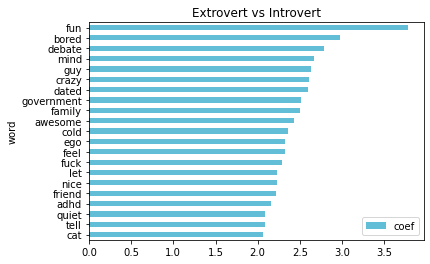

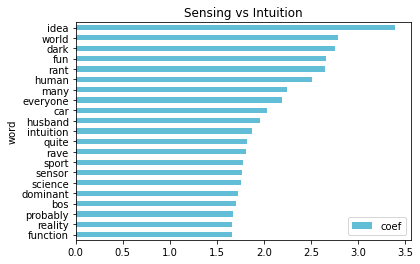

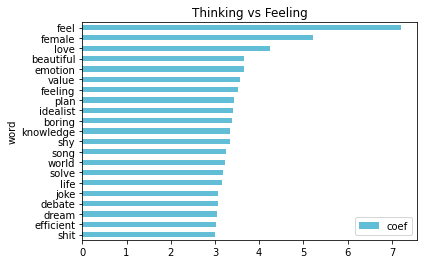

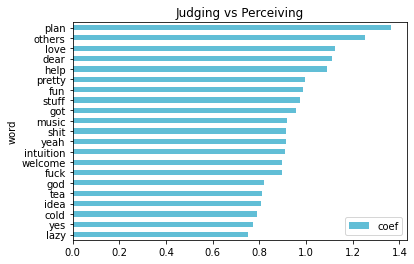

In [11]:
%%time

for col in y.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = imb_make_pipeline(
        preprocesser_tf,
        RandomUnderSampler(),
        LogisticRegressionCV()
    )
    
    # training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)
    
    # feature importance   
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_["tfidf"].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=["word", "coef"]).set_index("word")    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])